Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb
import zipfile as zf
import time
from tkinter import  *
import joblib
from tkinter import messagebox

Unzip Data

In [56]:
files = zf.ZipFile("data.zip", 'r')
files.extractall('data')
files.close()

function to return the class of the images from its number, so the function would return 'Normal' if given 0, and 'PNEUMONIA' if given 1.

In [8]:
code = {'NORMAL':0 ,'PNEUMONIA':1}
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

Feature extraction from  data set with Mean Pixel Value of Channels and resize images to 64 x 64 pixels

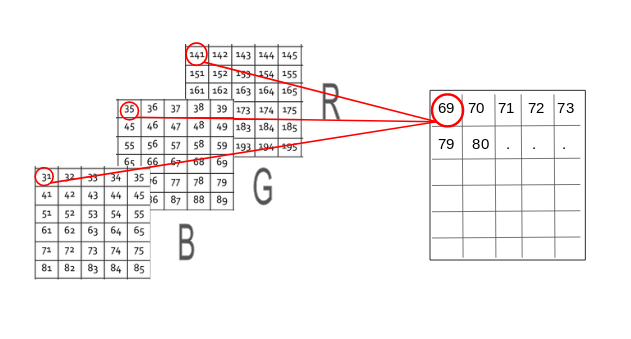

Feature extraction from train set

In [5]:
trainpath='data/chest_xray/chest_xray/train/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        feature_matrix = np.zeros((64,64)) 
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        for i in range(0,image_array.shape[0]):
            for j in range(0,image_array.shape[1]):
                feature_matrix[i][j] = ((int(image_array[i,j,0]) + int(image_array[i,j,1]) + int(image_array[i,j,2]))/3)

        image_ar = np.reshape(feature_matrix, (64*64)) 
        X_train.append(list(image_ar))
        y_train.append(code[folder])
np.save('X_train',X_train)
np.save('y_train',y_train)

Feature extraction from  test set

In [6]:
#the directory that contain the test images set
testpath='data/chest_xray/chest_xray/test/'

X_test = []
y_test = []
for folder in  os.listdir(testpath) : 
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        feature_matrix = np.zeros((64,64)) 
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        for i in range(0,image_array.shape[0]):
            for j in range(0,image_array.shape[1]):
                feature_matrix[i][j] = ((int(image_array[i,j,0]) + int(image_array[i,j,1]) + int(image_array[i,j,2]))/3)

        image_ar = np.reshape(feature_matrix, (64*64)) 
        X_test.append(list(image_ar))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

Make histograms for pixel intensity of an image

In [39]:
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    a = cv2.imread(a)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)

On the left you can see the photo and on the right the pixel histogram.
We notice that the channel that contains the most pixels is the third one. 
Τhe values ​​in the area we are interested in are between 50 and 200.

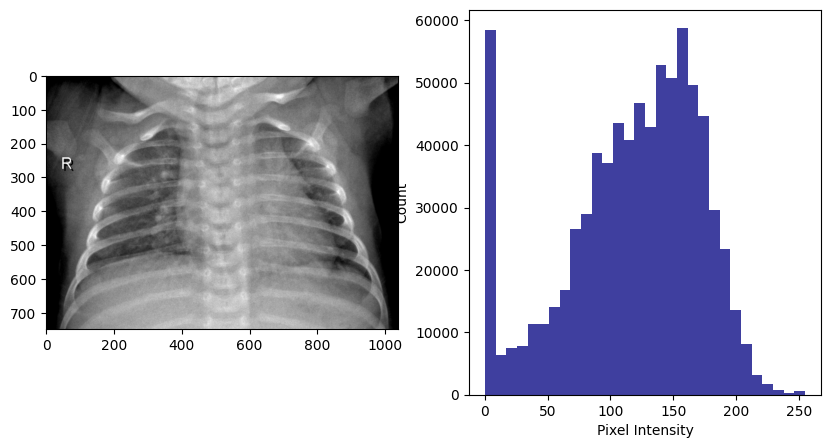

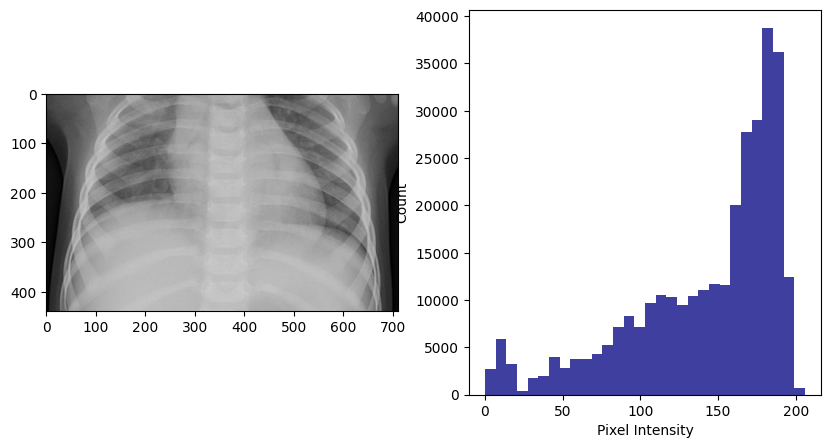

In [47]:
plotHistogram('data/chest_xray/train/NORMAL/IM-0206-0001.jpeg')
plotHistogram('data/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')

We use Scale-Invariant Feature Transform algorithm in order to marking the keypoints on the image

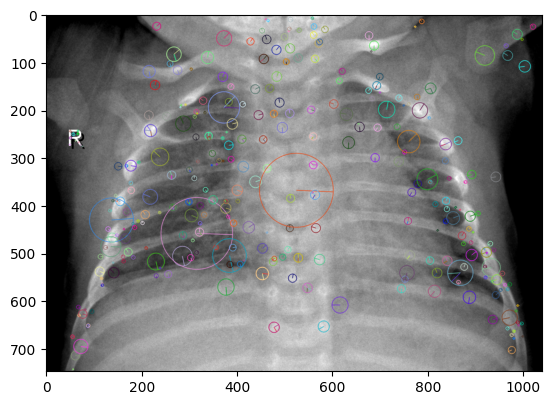

In [4]:
#reading image
img = cv2.imread('data/chest_xray/train/NORMAL/IM-0206-0001.jpeg')  

 # Converting image to grayscale
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
# Applying SIFT detector
sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
 
# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
plt.imshow(img)

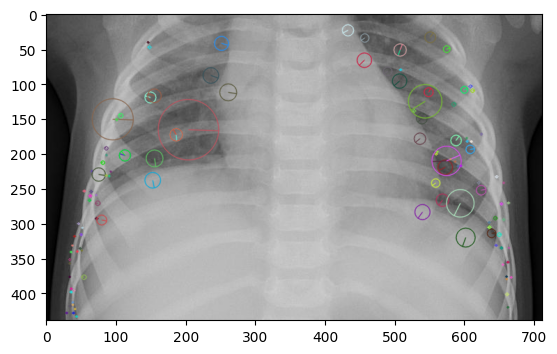

In [46]:
#reading image
img = cv2.imread('data/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')  

 # Converting image to grayscale
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
 
# Applying SIFT detector
sift = cv2.SIFT_create()
kp = sift.detect(gray, None)
 
# Marking the keypoint on the image using circles
img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 
plt.imshow(img)

Next, let’s try and match the features from image 1 with features from image 2.
We will be using the function match() from the BFmatcher (brute force match) module. 
Also, we will draw lines between the features that match both images.

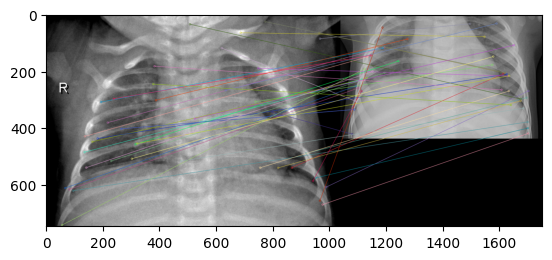

(<matplotlib.image.AxesImage at 0x1b92ce93470>, None)

In [9]:
# read images
img1 = cv2.imread('data/chest_xray/train/NORMAL/IM-0206-0001.jpeg')  
img2 = cv2.imread('data/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')  

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()

Load features

In [14]:
loaded_X_train = np.load('./X_train.npy')
loaded_X_test = np.load('./X_test.npy')
loaded_y_train = np.load('./y_train.npy')
loaded_y_test = np.load('./y_test.npy')

Import features in dataframe

In [9]:
df_train = pd.DataFrame()
df_train["labels"]= loaded_y_train
for ind in df_train.index:
    if df_train['labels'][ind] == 0:
        df_train['labels'][ind] = "Normal"
    if df_train['labels'][ind] == 1:
        df_train['labels'][ind] = "Pneumonia"
      
df_test = pd.DataFrame()
df_test["labels"]= loaded_y_test
for ind in df_test.index:
    if df_test['labels'][ind] == 0:
        df_test['labels'][ind] = "Normal"
    if df_test['labels'][ind] == 1:
        df_test['labels'][ind] = "Pneumonia"
           




C:\Users\George\AppData\Local\Temp\ipykernel_13464\2260582741.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Normal' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_train['labels'][ind] = "Normal"
C:\Users\George\AppData\Local\Temp\ipykernel_13464\2260582741.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Normal' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_test['labels'][ind] = "Normal"
C:\Users\George\AppData\Local\Temp\ipykernel_13464\2260582741.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Normal' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_val['labels'][ind] = "Normal"


Description of the datsets

Text(0.5, 1.0, 'Train')

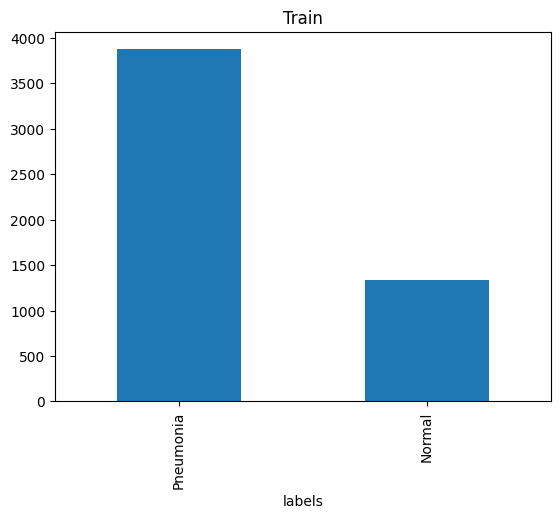

In [10]:

df_train['labels'].value_counts().plot( 
    kind='bar',  
  ) 
plt.title("Train")

Text(0.5, 1.0, 'Test')

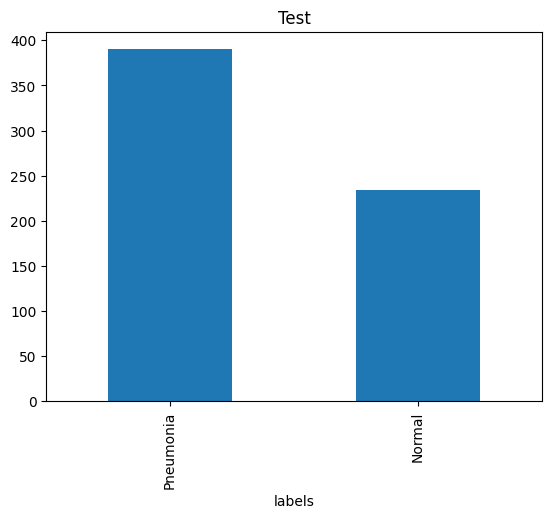

In [11]:
df_test['labels'].value_counts().plot( 
    kind='bar',  
  ) 
plt.title("Test")

Text(0.5, 1.0, 'Train')

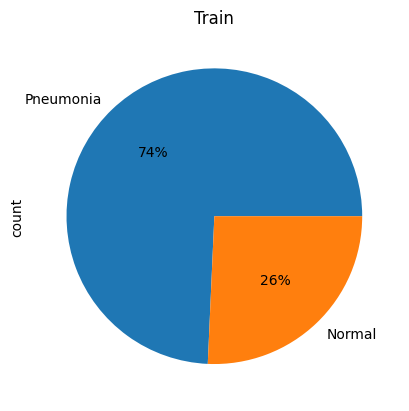

In [13]:
df_train["labels"].value_counts().plot( 
    kind='pie',  
  autopct='%1.0f%%' ) 
plt.title("Train")

Text(0.5, 1.0, 'Test')

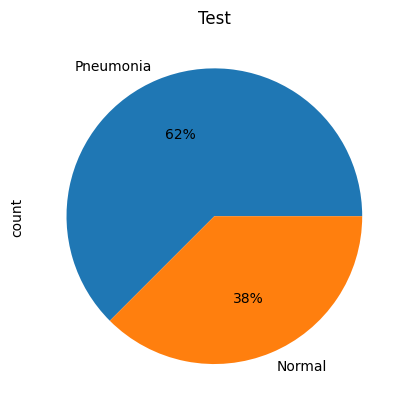

In [14]:
df_test["labels"].value_counts().plot( 
    kind='pie',  
  autopct='%1.0f%%' ) 
plt.title("Test")

Dimensions of each array

In [15]:
print(loaded_X_train.shape) 
print(loaded_X_test.shape) 

(5216, 4096)
(624, 4096)


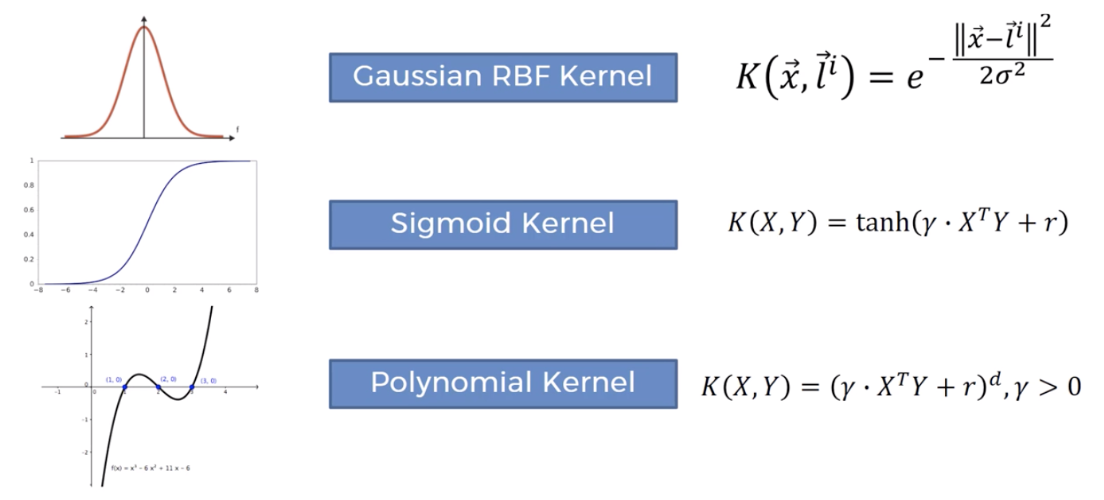

The StandardScaler class in Scikit-Learn can be used to normalize data to have zero mean and unit variance.

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

X_sctest = scaler.fit_transform(X_test)


NameError: name 'X_train' is not defined

Hyperparameter Tuning for svm with rbf kernel

Best parameters are {'C': 0.001, 'gamma': 0.0001} 
Score : 100.0%


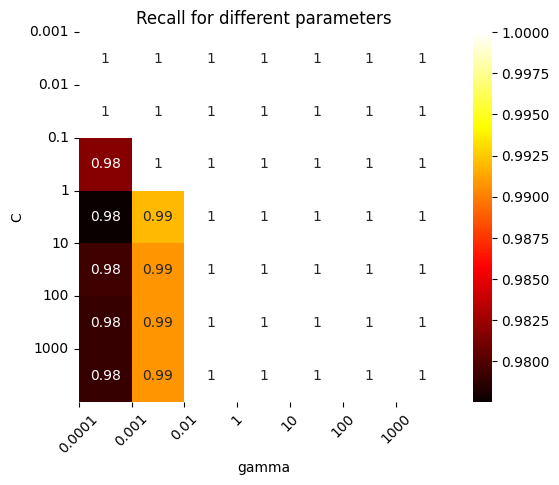

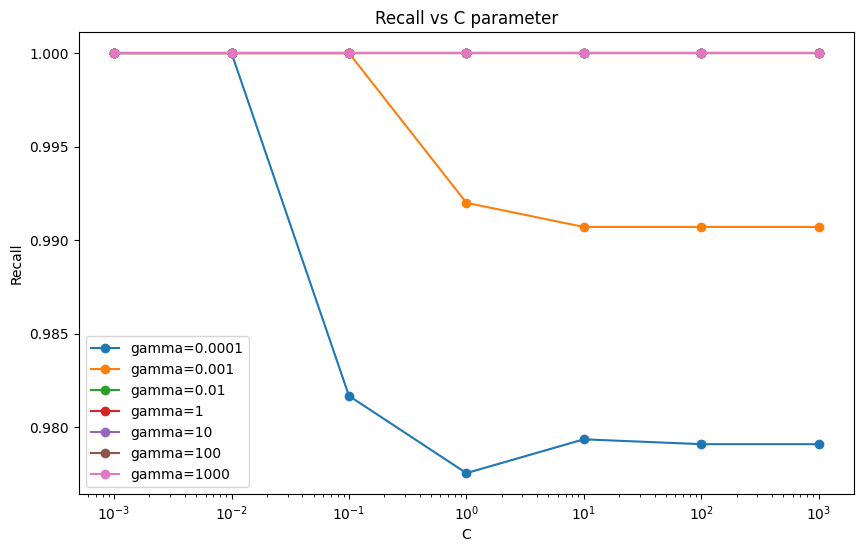

In [56]:

 
# define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
 
# perform grid search
svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,scoring='recall')
grid_search.fit(X_scaled, y_train)
 
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search.best_params_, grid_search.best_score_*100)
)
 
# Reshape for heatmap
scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['gamma']),
    len(param_grid['C']))
 
# Heatmap
sns.heatmap(scores, 
            cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            square=True)
 
plt.xlabel("gamma")
plt.ylabel("C")
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=0)
 
plt.title("Recall for different parameters")
plt.show()
 
## Plot accuracy vs C parameter
plt.figure(figsize=(10, 6))
plt.title("Recall vs C parameter")
plt.xlabel("C")
plt.ylabel("Recall")
n = len(param_grid['C'])
for i in range(n):
    plt.plot(param_grid['C'], 
             scores[:,i], 
             'o-', label='gamma='+str(param_grid['gamma'][i]))
 
plt.legend()
plt.xscale('log')
plt.show()

Best parameters are {'C': 100, 'gamma': 0.0001} 
Score : 98.06388598594788%


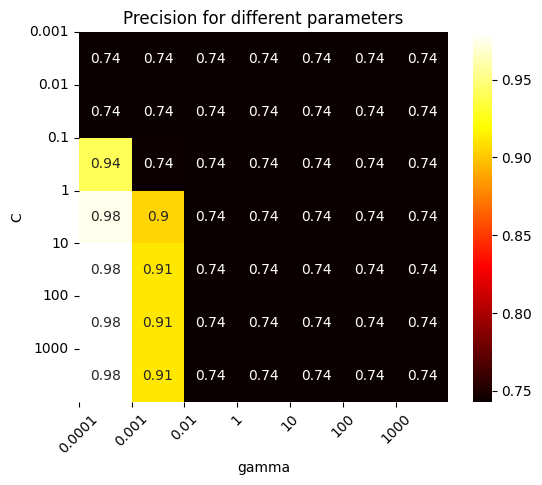

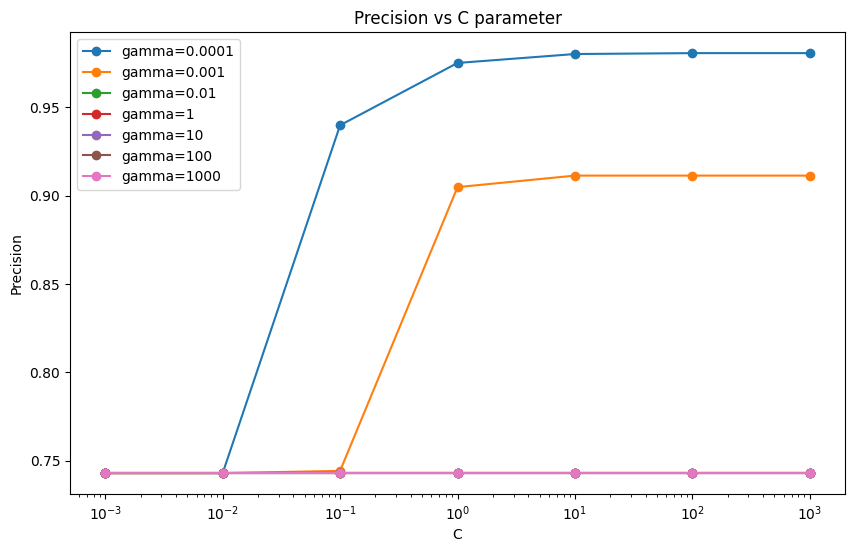

In [57]:

 
# define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
 
# perform grid search
svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,scoring='precision')
grid_search.fit(X_scaled, y_train)
 
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search.best_params_, grid_search.best_score_*100)
)
 
# Reshape for heatmap
scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['gamma']),
    len(param_grid['C']))
 
# Heatmap
sns.heatmap(scores, 
            cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            square=True)
 
plt.xlabel("gamma")
plt.ylabel("C")
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=0)
 
plt.title("Precision for different parameters")
plt.show()
 
## Plot accuracy vs C parameter
plt.figure(figsize=(10, 6))
plt.title("Precision vs C parameter")
plt.xlabel("C")
plt.ylabel("Precision")
n = len(param_grid['C'])
for i in range(n):
    plt.plot(param_grid['C'], 
             scores[:,i], 
             'o-', label='gamma='+str(param_grid['gamma'][i]))
 
plt.legend()
plt.xscale('log')
plt.show()

Hyperparameter Tuning for svm with polynomial kernel

Best parameters are {'C': 0.001, 'gamma': 0.0001} 
Score : 100.0%


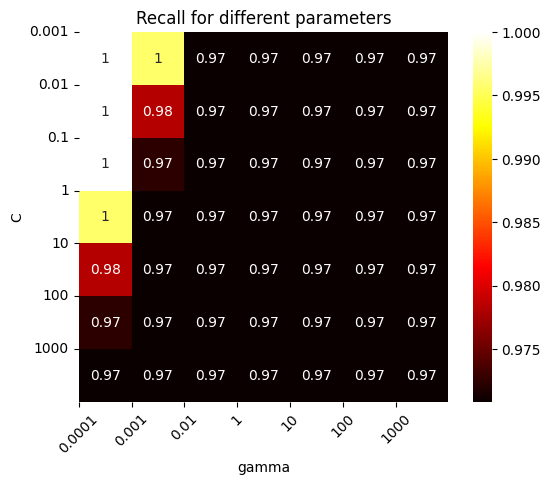

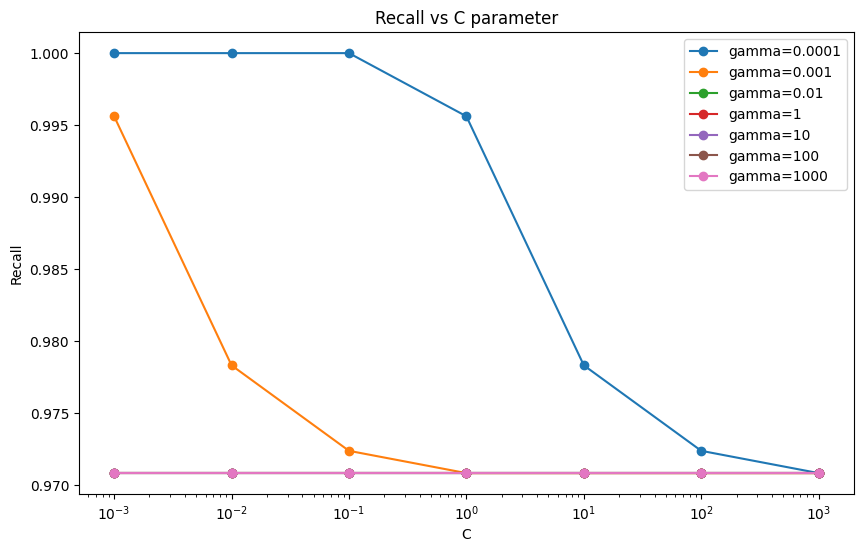

In [59]:

 
# define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
 
# perform grid search
svm = SVC(kernel='poly')
grid_search = GridSearchCV(svm, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,scoring='recall')
grid_search.fit(X_scaled, y_train)
 
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search.best_params_, grid_search.best_score_*100)
)
 
# Reshape for heatmap
scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['gamma']),
    len(param_grid['C']))
 
# Heatmap
sns.heatmap(scores, 
            cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            square=True)
 
plt.xlabel("gamma")
plt.ylabel("C")
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=0)
 
plt.title("Recall for different parameters")
plt.show()
 
## Plot accuracy vs C parameter
plt.figure(figsize=(10, 6))
plt.title("Recall vs C parameter")
plt.xlabel("C")
plt.ylabel("Recall")
n = len(param_grid['C'])
for i in range(n):
    plt.plot(param_grid['C'], 
             scores[:,i], 
             'o-', label='gamma='+str(param_grid['gamma'][i]))
 
plt.legend()
plt.xscale('log')
plt.show()

Best parameters are {'C': 0.001, 'gamma': 0.01} 
Score : 95.65000180675328%


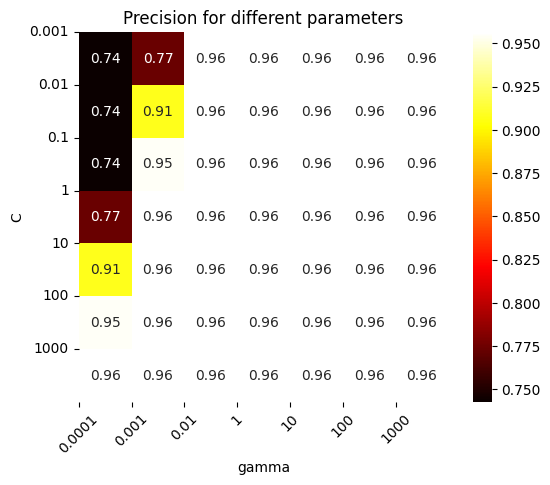

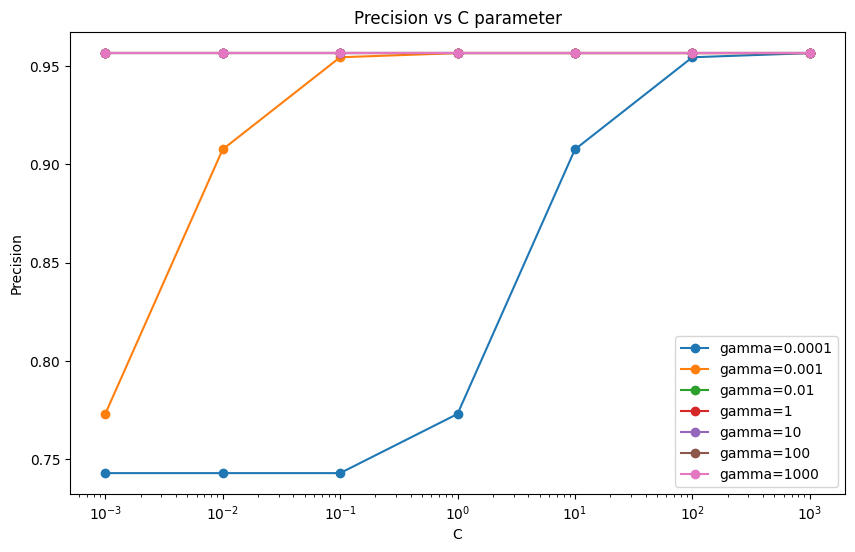

In [60]:

 
# define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
 
# perform grid search
svm = SVC(kernel='poly')
grid_search = GridSearchCV(svm, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,scoring='precision')
grid_search.fit(X_scaled, y_train)
 
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search.best_params_, grid_search.best_score_*100)
)
 
# Reshape for heatmap
scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['gamma']),
    len(param_grid['C']))
 
# Heatmap
sns.heatmap(scores, 
            cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            square=True)
 
plt.xlabel("gamma")
plt.ylabel("C")
plt.xticks(np.arange(len(param_grid['gamma'])), param_grid['gamma'], rotation=45)
plt.yticks(np.arange(len(param_grid['C'])), param_grid['C'], rotation=0)
 
plt.title("Precision for different parameters")
plt.show()
 
## Plot accuracy vs C parameter
plt.figure(figsize=(10, 6))
plt.title("Precision vs C parameter")
plt.xlabel("C")
plt.ylabel("Precision")
n = len(param_grid['C'])
for i in range(n):
    plt.plot(param_grid['C'], 
             scores[:,i], 
             'o-', label='gamma='+str(param_grid['gamma'][i]))
 
plt.legend()
plt.xscale('log')
plt.show()

Hyperparameter Tuning for random forest

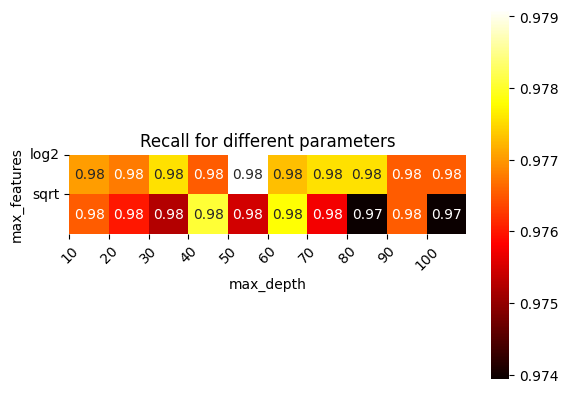

In [33]:

 
# define the parameter grid
param_grid = {'max_depth': [10,20 , 30, 40, 50,60,70,80,90,100],
              'max_features':['log2', 'sqrt']}
 
# perform grid search
rfc = RandomForestClassifier()

grid_search = GridSearchCV(rfc, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,scoring='recall')
grid_search.fit(X_scaled, y_train)

 
# Reshape for heatmap
scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['max_features']),
    len(param_grid['max_depth']))
 
# Heatmap
sns.heatmap(scores, 
            cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            square=True)
 
plt.xlabel("max_depth")
plt.ylabel("max_features")
plt.xticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'], rotation=45)
plt.yticks(np.arange(len(param_grid['max_features'])), param_grid['max_features'], rotation=0)
 
plt.title("Recall for different parameters")
plt.show()
 

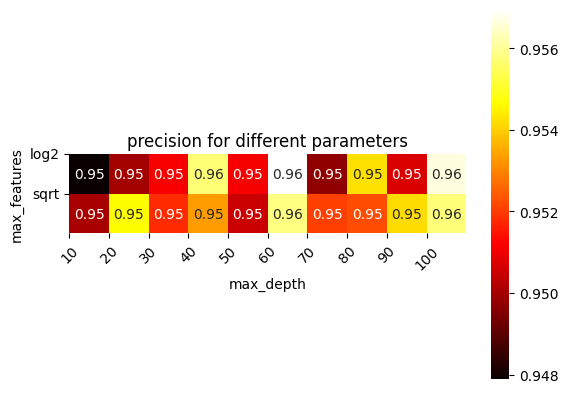

In [34]:

 
# define the parameter grid
param_grid = {'max_depth': [10,20 , 30, 40, 50,60,70,80,90,100],
              'max_features':['log2', 'sqrt']}
 
# perform grid search
rfc = RandomForestClassifier()

grid_search = GridSearchCV(rfc, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,scoring='precision')
grid_search.fit(X_scaled, y_train)
 
 
# Reshape for heatmap
scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['max_features']),
    len(param_grid['max_depth']))
 
# Heatmap
sns.heatmap(scores, 
            cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            square=True)
 
plt.xlabel("max_depth")
plt.ylabel("max_features")
plt.xticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'], rotation=45)
plt.yticks(np.arange(len(param_grid['max_features'])), param_grid['max_features'], rotation=0)
 
plt.title("precision for different parameters")
plt.show()
 

Hyperparameter Tuning for decision-tree

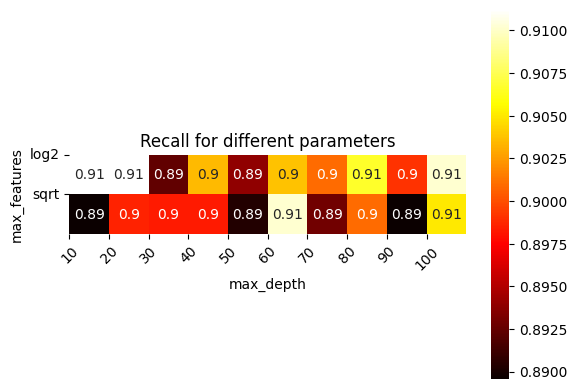

In [40]:

 
# define the parameter grid
param_grid = {'max_depth': [10,20 , 30, 40, 50,60,70,80,90,100],
              'max_features':['log2', 'sqrt']}
 
# perform grid search
dtc  = DecisionTreeClassifier()

grid_search = GridSearchCV(dtc, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,scoring='recall')
grid_search.fit(X_scaled, y_train)

 
# Reshape for heatmap
scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['max_features']),
    len(param_grid['max_depth']))
 
# Heatmap
sns.heatmap(scores, 
            cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            square=True)
 
plt.xlabel("max_depth")
plt.ylabel("max_features")
plt.xticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'], rotation=45)
plt.yticks(np.arange(len(param_grid['max_features'])), param_grid['max_features'], rotation=0)
 
plt.title("Recall for different parameters")
plt.show()
 

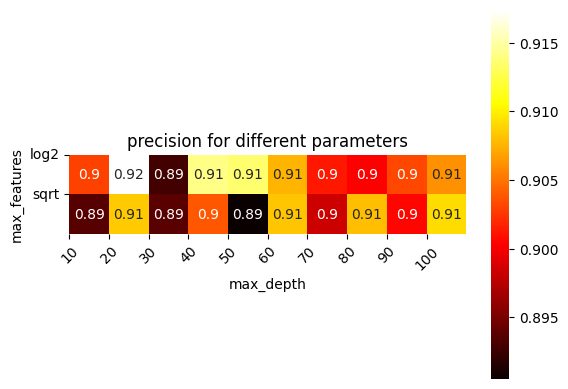

In [41]:

 
# define the parameter grid
param_grid = {'max_depth': [10,20 , 30, 40, 50,60,70,80,90,100],
              'max_features':['log2', 'sqrt']}
 
# perform grid search
dtc  = DecisionTreeClassifier()

grid_search = GridSearchCV(dtc, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,scoring='precision')
grid_search.fit(X_scaled, y_train)
 
 
# Reshape for heatmap
scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['max_features']),
    len(param_grid['max_depth']))
 
# Heatmap
sns.heatmap(scores, 
            cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            square=True)
 
plt.xlabel("max_depth")
plt.ylabel("max_features")
plt.xticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'], rotation=45)
plt.yticks(np.arange(len(param_grid['max_features'])), param_grid['max_features'], rotation=0)
 
plt.title("precision for different parameters")
plt.show()
 

Hyperparameter Tuning for KNN

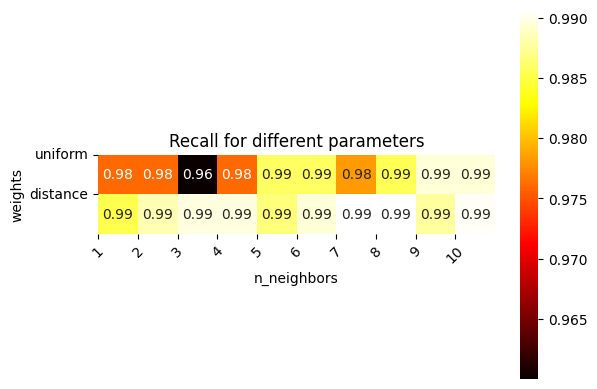

In [46]:

 
# define the parameter grid
param_grid = {'n_neighbors': np.arange(1, 11),
              'weights': ['uniform', 'distance'],}
 
# perform grid search
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,scoring='recall')
grid_search.fit(X_scaled, y_train)

 
# Reshape for heatmap
scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['weights']),
    len(param_grid['n_neighbors']))
 
# Heatmap
sns.heatmap(scores, 
            cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            square=True)
 
plt.xlabel("n_neighbors")
plt.ylabel("weights")
plt.xticks(np.arange(len(param_grid['n_neighbors'])), param_grid['n_neighbors'], rotation=45)
plt.yticks(np.arange(len(param_grid['weights'])), param_grid['weights'], rotation=0)
 
plt.title("Recall for different parameters")
plt.show()
 

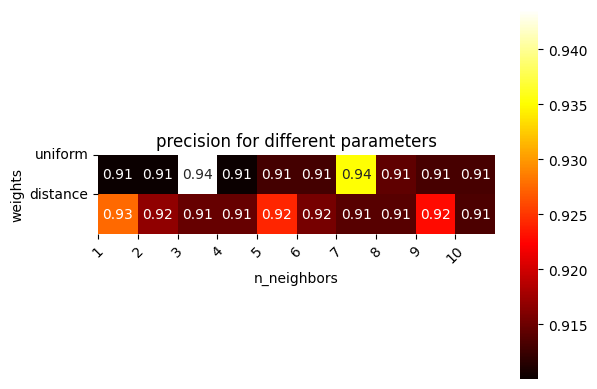

In [47]:

 
# define the parameter grid
param_grid = {'n_neighbors': np.arange(1, 11),
              'weights': ['uniform', 'distance'],}
 
# perform grid search
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1,scoring='precision')
grid_search.fit(X_scaled, y_train)

 
# Reshape for heatmap
scores = grid_search.cv_results_["mean_test_score"].reshape(
    len(param_grid['weights']),
    len(param_grid['n_neighbors']))
 
# Heatmap
sns.heatmap(scores, 
            cmap = plt.cm.hot,
            annot= True, 
            cbar= True, 
            square=True)
 
plt.xlabel("n_neighbors")
plt.ylabel("weights")
plt.xticks(np.arange(len(param_grid['n_neighbors'])), param_grid['n_neighbors'], rotation=45)
plt.yticks(np.arange(len(param_grid['weights'])), param_grid['weights'], rotation=0)
 
plt.title("precision for different parameters")
plt.show()
 

In [9]:
svm_rbf = SVC( C=100, gamma = 0.0001, kernel='rbf' )
svm_poly = SVC( C=1, gamma = 0.001, kernel='poly' )
rfc = RandomForestClassifier(max_depth=50,max_features='log2')
dtc  = DecisionTreeClassifier(max_depth=20,max_features='log2')
knn = KNeighborsClassifier(n_neighbors=7,weights='uniform')
t0=time.time()
svm_rbf.fit(X_scaled,y_train)
rbf_ttime=time.time()-t0
t0=time.time()
svm_poly.fit(X_scaled,y_train)
poly_ttime=time.time()-t0
t0=time.time()
rfc.fit(X_scaled,y_train)
rfc_ttime=time.time()-t0
t0=time.time()
dtc.fit(X_scaled,y_train)
dtc_ttime=time.time()-t0
t0=time.time()
knn.fit(X_scaled,y_train)
knn_ttime=time.time()-t0

In [10]:
t0=time.time()
svm_rbf_predcited = svm_rbf.predict(X_sctest)
rbf_ptime=time.time()-t0

t0=time.time()
svm_poly_predcited = svm_poly.predict(X_sctest)
poly_ptime=time.time()-t0

t0=time.time()
rfc_predcited = rfc.predict(X_sctest)
rfc_ptime=time.time()-t0

t0=time.time()
dtc_predcited = dtc.predict(X_sctest)
dtc_ptime=time.time()-t0

t0=time.time()
knn_predcited = knn.predict(X_sctest)
knn_ptime=time.time()-t0

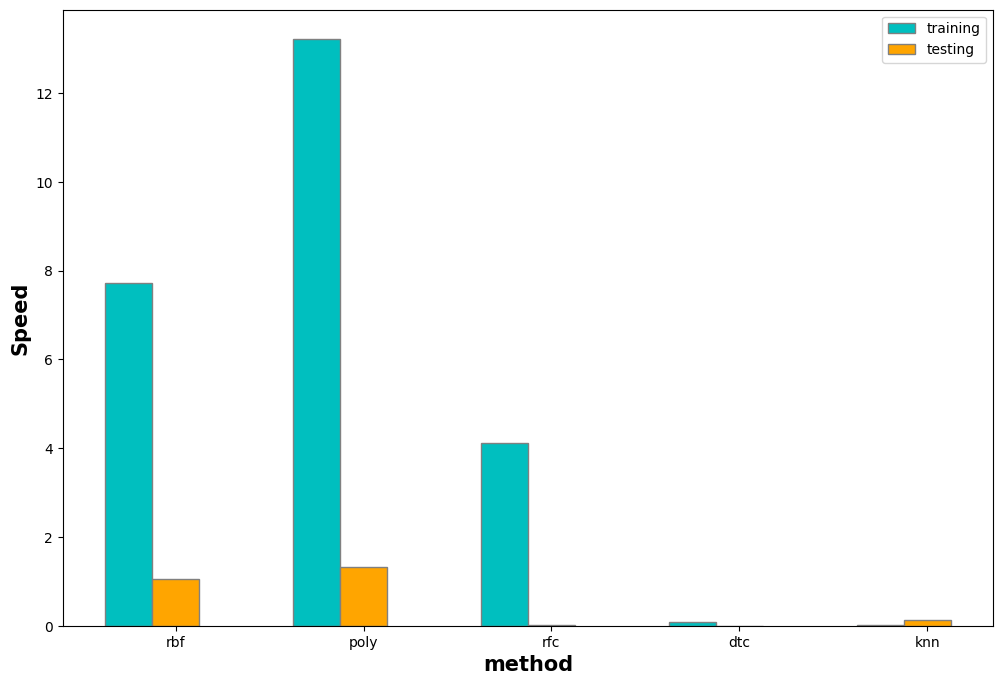

In [34]:
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
 
# set height of bar 
training = [rbf_ttime, poly_ttime, rfc_ttime,dtc_ttime, knn_ttime] 
testing = [rbf_ptime, poly_ptime, rfc_ptime,dtc_ptime, knn_ptime] 
 
# Set position of bar on X axis 
br1 = np.arange(len(training)) 
br2 = [x + barWidth for x in br1]  
 
# Make the plot
plt.bar(br1, training, color ='c', width = barWidth, 
        edgecolor ='grey', label ='training') 
plt.bar(br2, testing, color ='orange', width = barWidth, 
        edgecolor ='grey', label ='testing') 
 
# Adding Xticks 
plt.xlabel('method', fontweight ='bold', fontsize = 15) 
plt.ylabel('Speed', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(training))], 
        ['rbf', 'poly', 'rfc', 'dtc', 'knn'])
 
plt.legend()
plt.show() 

In [49]:
print('Support Vector Machine Classifier accuracy with rbf kernel score is: ' + str(svm_rbf.score(X_sctest, y_test)))
print('Support Vector Machine Classifier accuracy with polynomial kernel score is: ' + str(svm_poly.score(X_sctest, y_test)))
print('Random Forest score is: ' + str(rfc.score(X_sctest, y_test)))
print('Decision Tree score is: ' + str(dtc.score(X_sctest, y_test)))
print('KNN score is: ' + str(knn.score(X_sctest, y_test)))

Support Vector Machine Classifier accuracy with rbf kernel score is: 0.8044871794871795
Support Vector Machine Classifier accuracy with polynomial kernel score is: 0.7900641025641025
Random Forest score is: 0.780448717948718
Decision Tree score is: 0.7099358974358975
KNN score is: 0.7307692307692307


In [11]:
#making predictions for each model
svm_rbf_predcited = svm_rbf.predict(X_sctest)
tn, fp, fn, tp = confusion_matrix(y_test, svm_rbf_predcited).ravel()
precision_score_rbf = tp / (tp + fp)
recall_score_rbf = tp / (tp + fn)
accuracy_score_rbf = (tp+tn)/(tp+fp+tn+fn)
f1_score_rbf = (2*recall_score_rbf*precision_score_rbf)/(recall_score_rbf+precision_score_rbf)
print('Support Vector Machine Classifier with rbf kernel')
print('accuracy score is:' +str(accuracy_score_rbf))
print('recall score is:' +str(recall_score_rbf))
print('precision score is:' +str(precision_score_rbf))
print('f1 score is:' +str(f1_score_rbf))

svm_poly_predcited = svm_poly.predict(X_sctest)
tn, fp, fn, tp = confusion_matrix(y_test, svm_poly_predcited).ravel()
precision_score_poly = tp / (tp + fp)
recall_score_poly = tp / (tp + fn)
accuracy_score_poly = (tp+tn)/(tp+fp+tn+fn)
f1_score_poly = (2*recall_score_poly*precision_score_poly)/(recall_score_poly+precision_score_poly)
print('Support Vector Machine Classifier with polynomial kernell')
print('accuracy score is:' +str(accuracy_score_poly))
print('recall score is:' +str(recall_score_poly))
print('precision score is:' +str(precision_score_poly))
print('f1 score is:' +str(f1_score_poly))


rfc_predcited = rfc.predict(X_sctest)
tn, fp, fn, tp = confusion_matrix(y_test, rfc_predcited).ravel()
precision_score_rfc = tp / (tp + fp)
recall_score_rfc = tp / (tp + fn)
accuracy_score_rfc = (tp+tn)/(tp+fp+tn+fn)
f1_score_rfc = (2*recall_score_rfc*precision_score_rfc)/(recall_score_rfc+precision_score_rfc)
print('Random Forest')
print('accuracy score is:' +str(accuracy_score_rfc))
print('recall score is:' +str(recall_score_rfc))
print('precision score is:' +str(precision_score_rfc))
print('f1 score is:' +str(f1_score_rfc))


dtc_predcited = dtc.predict(X_sctest)
tn, fp, fn, tp = confusion_matrix(y_test, dtc_predcited).ravel()
precision_score_dtc = tp / (tp + fp)
recall_score_dtc = tp / (tp + fn)
accuracy_score_dtc = (tp+tn)/(tp+fp+tn+fn)
f1_score_dtc = (2*recall_score_dtc*precision_score_dtc)/(recall_score_dtc+precision_score_dtc)
print('Decision Tree')
print('accuracy score is:' +str(accuracy_score_dtc))
print('recall score is:' +str(recall_score_dtc))
print('precision score is:' +str(precision_score_dtc))
print('f1 score is:' +str(f1_score_dtc))



knn_predcited = knn.predict(X_sctest)
tn, fp, fn, tp = confusion_matrix(y_test, knn_predcited).ravel()
precision_score_knn = tp / (tp + fp)
recall_score_knn = tp / (tp + fn)
accuracy_score_knn = (tp+tn)/(tp+fp+tn+fn)
f1_score_knn = (2*recall_score_knn*precision_score_knn)/(recall_score_knn+precision_score_knn)
print('KNN')
print('accuracy score is:' +str(accuracy_score_knn))
print('recall score is:' +str(recall_score_knn))
print('precision score is:' +str(precision_score_knn))
print('f1 score is:' +str(f1_score_knn))


Support Vector Machine Classifier with rbf kernel
accuracy score is:0.8044871794871795
recall score is:0.9743589743589743
precision score is:0.7723577235772358
f1 score is:0.8616780045351473
Support Vector Machine Classifier with polynomial kernell
accuracy score is:0.7900641025641025
recall score is:0.9743589743589743
precision score is:0.7584830339321357
f1 score is:0.8529741863075196
Random Forest
accuracy score is:0.7916666666666666
recall score is:0.9897435897435898
precision score is:0.75390625
f1 score is:0.8558758314855877
Decision Tree
accuracy score is:0.6842948717948718
recall score is:0.8948717948717949
precision score is:0.691089108910891
f1 score is:0.7798882681564245
KNN
accuracy score is:0.7307692307692307
recall score is:0.9948717948717949
precision score is:0.7003610108303249
f1 score is:0.8220338983050848


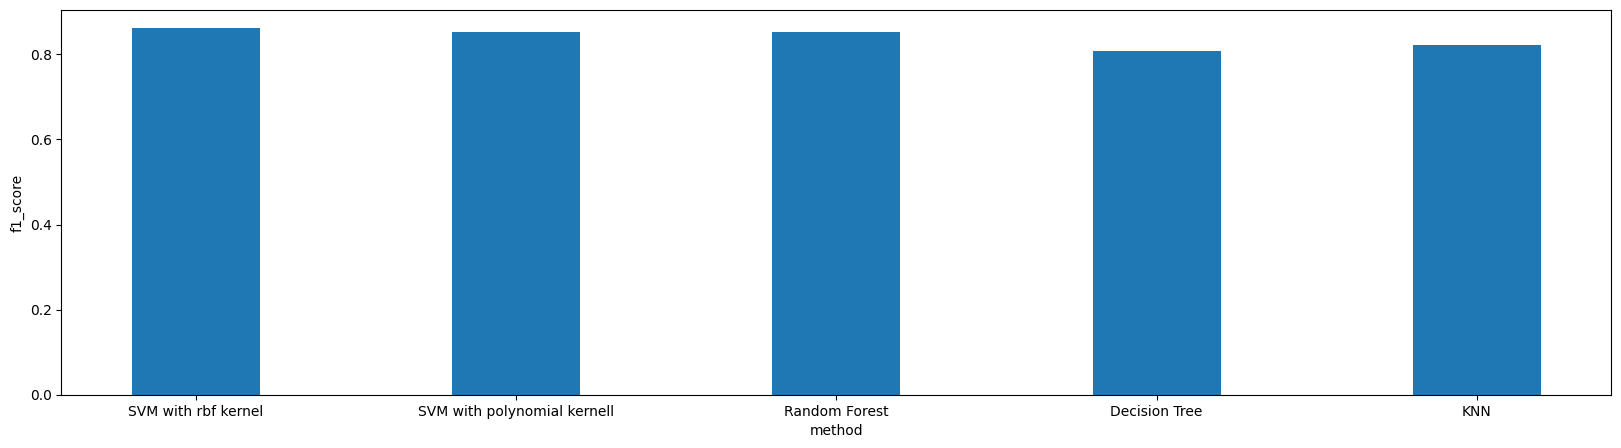

In [22]:
f1_table = {'SVM with rbf kernel':f1_score_rbf,
            'SVM with polynomial kernell':f1_score_poly, 'Random Forest':f1_score_rfc, 
            'Decision Tree':f1_score_dtc,'KNN':f1_score_knn }
algorithms = list(f1_table.keys())
values = list(f1_table.values())
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(algorithms, values, 
        width = 0.4)
 
plt.xlabel("method")
plt.ylabel("f1_score")
plt.show()

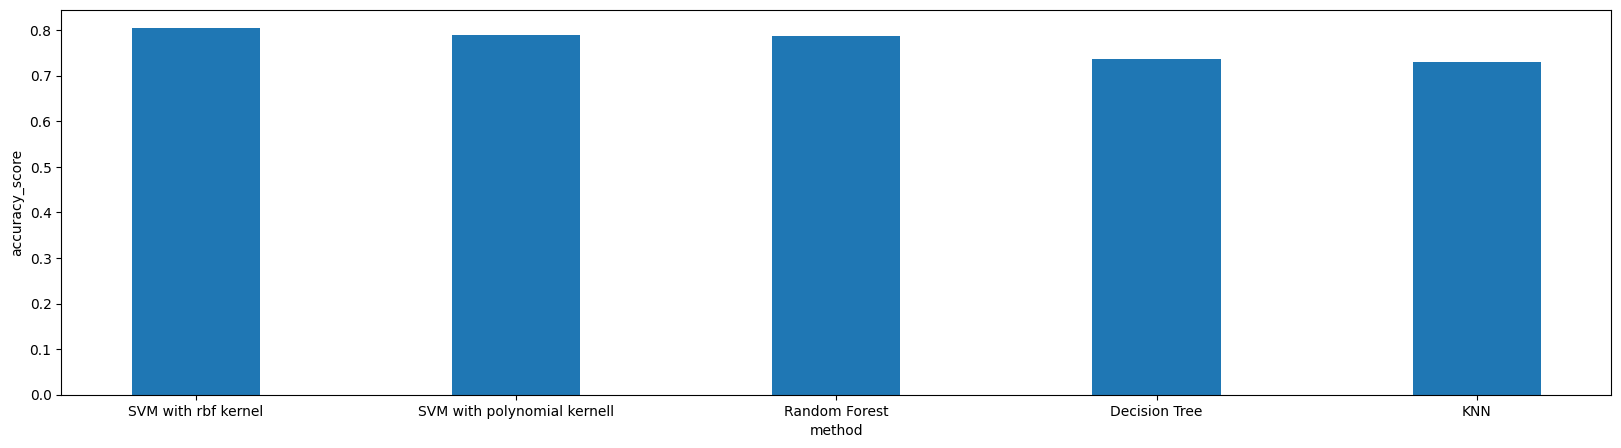

In [23]:
accuracy_table = {'SVM with rbf kernel':accuracy_score_rbf,
            'SVM with polynomial kernell':accuracy_score_poly, 'Random Forest':accuracy_score_rfc, 
            'Decision Tree':accuracy_score_dtc,'KNN':accuracy_score_knn }
algorithms = list(accuracy_table.keys())
values = list(accuracy_table.values())
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(algorithms, values, 
        width = 0.4)
 
plt.xlabel("method")
plt.ylabel("accuracy_score")
plt.show()

In [14]:
def plot_cm(predictions, y_test, title):
  labels = ['Normal', 'Pnuemonia']
  cm = confusion_matrix(y_test,predictions)
  cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
  plt.figure(figsize = (7,7))
  plt.title(title)
  sns.heatmap(cm, linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels)
  plt.show()

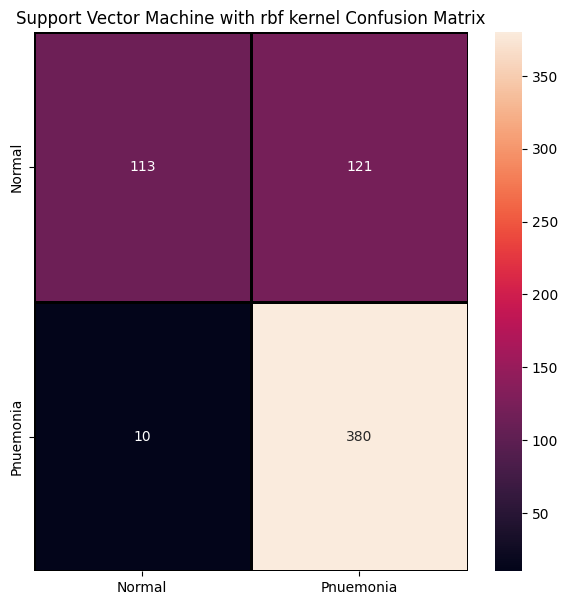

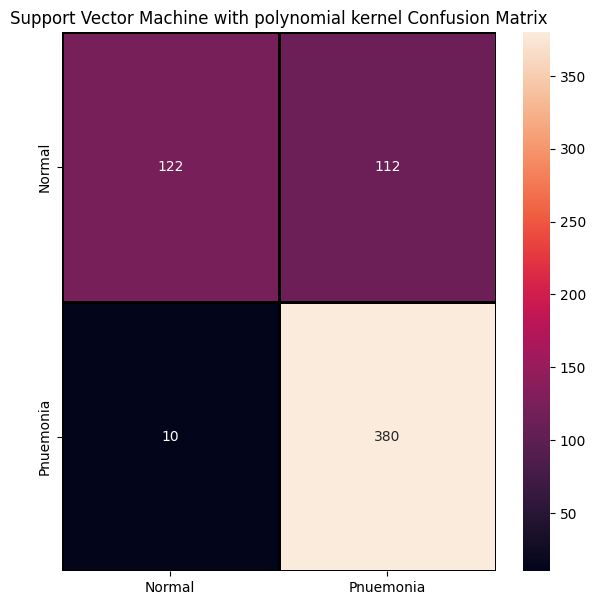

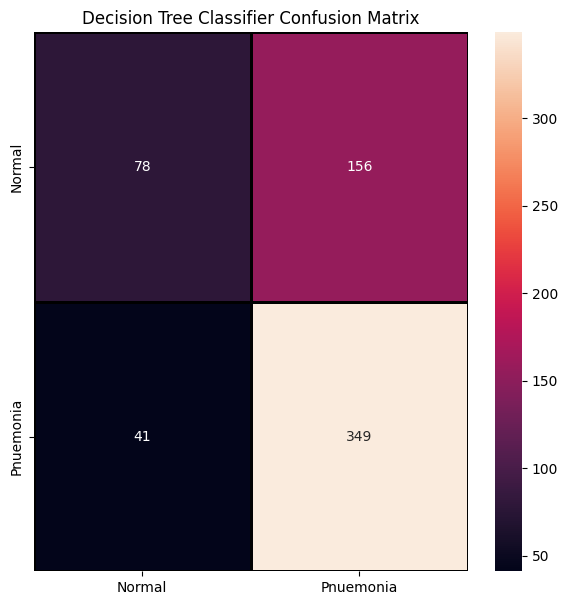

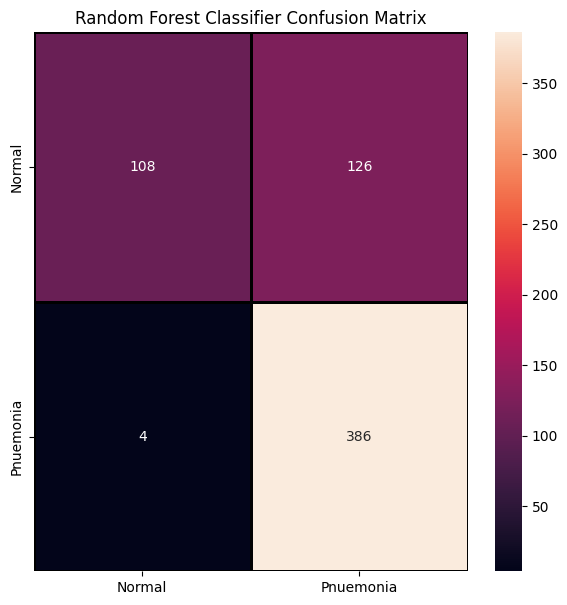

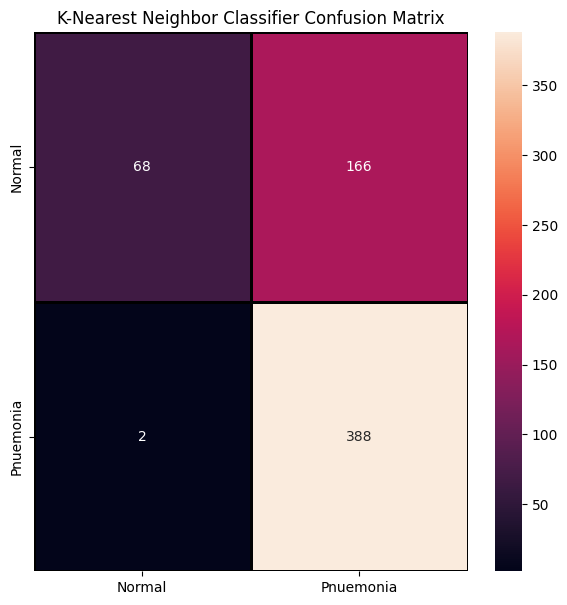

In [16]:
#plot confusion matrix for each model


plot_cm(svm_poly_predcited, y_test, 'Support Vector Machine with rbf kernel Confusion Matrix')
plot_cm(svm_rbf_predcited, y_test, 'Support Vector Machine with polynomial kernel Confusion Matrix')
plot_cm(dtc_predcited, y_test, 'Decision Tree Classifier Confusion Matrix')
plot_cm(rfc_predcited, y_test, 'Random Forest Classifier Confusion Matrix')
plot_cm(knn_predcited, y_test, 'K-Nearest Neighbor Classifier Confusion Matrix')

ML_UI

In [10]:
from tkinter import  *
import joblib
from tkinter import messagebox
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import pickle

In [5]:
files = zf.ZipFile("data_ui.zip", 'r')
files.extractall('data_ui')
files.close()

In [6]:
code = {'NORMAL':0 ,'PNEUMONIA':1}
#function to return the class of the images from its number, so the function would return 'Normal' if given 0, and 'PNEUMONIA' if given 1.
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [7]:
trainpath='data_ui/data/chest_xray/chest_xray/'

X_ui = []
y_ui = []
for folder in  os.listdir(trainpath) : 
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
    for file in files: 
        image = cv2.imread(file)
        feature_matrix = np.zeros((64,64)) 
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        for i in range(0,image_array.shape[0]):
            for j in range(0,image_array.shape[1]):
                feature_matrix[i][j] = ((int(image_array[i,j,0]) + int(image_array[i,j,1]) + int(image_array[i,j,2]))/3)

        image_ar = np.reshape(feature_matrix, (64*64)) 
        X_ui.append(list(image_ar))
        y_ui.append(code[folder])
np.save('X_ui',X_ui)
np.save('y_ui',y_ui)

In [9]:
scaler = StandardScaler()
X_scaledui = scaler.fit_transform(X_ui)


In [12]:
svm_rbf = SVC( C=100, gamma = 0.0001, kernel='rbf' )
svm_rbf.fit(X_scaledui,y_ui)
pickle.dump(svm_rbf, open('svm.pkl', 'wb'))

In [22]:


root = Tk()

root.title("Pneumonia Predictor")

root.geometry("600x400")


root.config(bg="lightblue")





def classify_button_click():
    pX_ui = []
    file = filedialog.askopenfilename()
    if  file:
            image = cv2.imread(file)
            feature_matrix = np.zeros((64,64)) 
            #resize images to 64 x 64 pixels
            image_array = cv2.resize(image , (64,64))
            for i in range(0,image_array.shape[0]):
                for j in range(0,image_array.shape[1]):
                    feature_matrix[i][j] = ((int(image_array[i,j,0]) + int(image_array[i,j,1]) + int(image_array[i,j,2]))/3)

            image_ar = np.reshape(feature_matrix, (64*64)) 
            pX_ui.append(list(image_ar))
            pX_scaledui = scaler.transform(pX_ui)
            pred = svm_rbf.predict(pX_scaledui)
            if pred == 0:
                vp="NORMAL"
            else:
                vp="PNEUMONIA"
    result_text.delete('1.0', tk.END)
    result_text.insert(tk.END, f"{vp}\n") 
    img = ImageTk.PhotoImage(Image.open(file).resize((100, 100)))
    image_label.config(image=img)
    image_label.image = img 
      
header = Label(root,text="Pneumonia Predictor",bg="lightblue",
     foreground="black",font=("Arial",15,"bold"))
header.pack()

frame1= Frame(root,bg="lightblue")
frame1.pack()

label1 = Label(frame1,text=" Chest X-Ray Image",bg="lightblue",foreground="black",
     font=("Arial",15,"bold"))
label1.grid(row=0,column=0,pady=10)

image_label = tk.Label(frame1,bg="lightblue")

image_label.grid(row=1,column=0,pady=2)

result_text = tk.Text(root,width=10, height=2)

browse_button = tk.Button(root, text="Browse", command=classify_button_click)



result_text.pack(pady=2)
browse_button.pack(pady=10)










root.mainloop()